In [1]:
import os
import re
import neptune.new as neptune
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from settings import MUJOCO, PYBULLET, ALGORITHMS, SEEDS
from typing import Dict, List, Set, Callable

from neptun_token import API_TOKEN

## Functions

### Modification data series

In [2]:
def slimming(data, window=10):
    data = data.rolling(window, min_periods=1).mean()
    data = pd.Series([sample for idx, sample in enumerate(data) if idx % window == 0])
    return data


def smoothen(data, window=10):
    return data.rolling(window, min_periods=1).mean()

### Downloading data from neptune

In [3]:
def download_basic_result_from_experiments(experiment_id: str) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_mean_reward = run['logs/train/mean_reward'].fetch_values(False)['value']
    train_std_reward = run['logs/train/std_reward'].fetch_values(False)['value']
    evaluate_mean_reward = run['logs/evaluate/mean_reward'].fetch_values(False)['value']
    evaluate_std_reward = run['logs/evaluate/std_reward'].fetch_values(False)['value']
    return {"logs/train/mean_reward": train_mean_reward,
            "logs/train/std_reward": train_std_reward,
            "logs/evaluate/mean_reward": evaluate_mean_reward,
            "logs/evaluate/std_reward": evaluate_std_reward}


def download_train_result_from_experiments(experiment_id: str, logs: List[str]) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_logs = [log for log in logs if re.match(r'logs/train/', log)]

    dict_with_log = {}
    for log in train_logs:
        series = run[log].fetch_values(False)['value']
        dict_with_log[log] = series
    return dict_with_log


def download_evaluate_result_from_experiments(experiment_id: str, logs: List[str]) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_logs = [log for log in logs if re.match(r'logs/evaluate/', log)]
    dict_with_log = {}
    for log in train_logs:
        dict_with_log[log] = run[log].fetch_values(False)['value']
    return dict_with_log

### Working with metadata

In [4]:
def selects_tags(tag_set: Set[str], regex_func: Callable) -> List[str]:
    selected_tags = []
    for tag in tag_set:
        if regex_func(tag):
            selected_tags.append(tag)
    return selected_tags


def get_all_existing_tags(neptune_project_table: pd.DataFrame) -> Set[str]:
    all_tags = set()
    for tags_line in neptune_project_table['sys/tags']:
        tags_list = tags_line.split(',')
        [all_tags.add(tag) for tag in tags_list]
    return all_tags


def get_tags_assigned_to_experiment_dict(neptune_project_table: pd.DataFrame):
    dictionary = neptune_project_table[['sys/id', 'sys/tags']].to_dict()
    tags_assigned_to_exp = {}
    for idx in dictionary['sys/id'].keys():
        tags_assigned_to_exp[dictionary['sys/id'][idx]] = dictionary['sys/tags'][idx].split(',')
    return tags_assigned_to_exp


def get_all_logs_name(neptune_project_table: pd.DataFrame) -> List[str]:
    logs = []
    for logs_name in neptune_project_table:
        if logs_name[:len('logs/')] == 'logs/':
            if logs_name != 'logs/Path to local files':   # ToDo: Don't log path in this way
                logs.append(logs_name)
    return logs


def select_specified_rows(algorithm: str, environment: str, tag_selector: Callable, frame: pd.DataFrame)\
        -> pd.DataFrame:
    """
    Creating data frame from rows tagged, by some algorithm, environment and fulfilling condition from tag_selector.
    """
    chosen_rows = []
    for row in frame.iterrows():
        row_tags = row[1]['sys/tags'].split(',')
        if algorithm in row_tags and environment in row_tags and selects_tags(set(row_tags), tag_selector):
            chosen_rows.append(row[1].to_dict())
    return pd.DataFrame(chosen_rows)

### Process logs

In [5]:
def concat_frames(experiments_results: pd.DataFrame, metric_name: str, slim=False, smooth=False):
    frames = []
    for experiment, metrics in experiments_results.items():
        log_series = metrics[metric_name]

        if slim: log_series = slimming(log_series, SMOOTHEN_WINDOW)
        if smooth: log_series = smoothen(log_series, SMOOTHEN_WINDOW)

        frame = pd.DataFrame({'tag': \
                    pd.Series([selects_tags(tags_assigned_to_exp[experiment], tag_selector)[0] for _ in range(len(log_series))]),
                              'steps': pd.Series([step*SMOOTHEN_WINDOW for step in range(len(log_series))]),
                              metric_name: log_series})
        frames.append(frame)

    return pd.concat(frames)


def make_plots(algo_name: str, env_name: str, path_to_experiment: str, frame_with_logs: pd.DataFrame):
    for log, frames in tqdm(frame_with_logs.items(), desc="Saving plots of results"):
        path_to_image = os.path.join(path_to_experiment, f"{log.replace('/', '_')}.png")
        if os.path.exists(path_to_image):
            continue

        plot = sns.relplot(x="steps", y=log, hue="tag", kind="line", data=frames)
        plot.fig.suptitle(algo_name + ' ' + env_name)
        plot.savefig(path_to_image)

# Example data preparing

## Setting global constants

In [6]:
PROJECT_NAME = 'nkrsi/rl-first-run'

ENV_TAGS = MUJOCO
ALGO_TAGS = ALGORITHMS

BASIC_LOGS = ["logs/train/mean_reward", "logs/train/std_reward", "logs/evaluate/mean_reward",
              "logs/evaluate/std_reward"]

SMOOTHEN_WINDOW = 100

# Setting plotting parameters
sns.set_theme(color_codes=True)
sns.set(rc={"figure.figsize": (3, 8)})

## Initializate connection to neptune and prepared metadata

In [7]:
project = neptune.get_project(name=PROJECT_NAME, api_token=API_TOKEN)
project_table = project.fetch_runs_table(owner='nkrsi')
project_table = project_table.to_pandas()

### Tags for example experiments

In [ ]:
algorithm = 'PPO'
environment = 'HalfCheetah-v2'
experiment_name = 'dropout'
tag_selector = lambda x: re.match(r'dropout', x)

base_dir = os.path.join(os.getcwd(), 'experiment_result')
base_dir

In [ ]:
all_tags_in_projects = get_all_existing_tags(project_table)
#dropout_tags = selects_tags(all_tags_in_projects, lambda tag: re.match(r'dropout', tag))

chosen_projects_table = select_specified_rows(algorithm, environment, tag_selector, project_table)

tags_assigned_to_exp = get_tags_assigned_to_experiment_dict(chosen_projects_table)
experiments = list(chosen_projects_table['sys/id'])
all_tags_in_projects = get_all_existing_tags(chosen_projects_table)
logs = get_all_logs_name(chosen_projects_table)

print()
print("Experimentes name")
print(experiments)

print()
print("Tags in metadata")
print(all_tags_in_projects)

print()
print("Experiments with tags")
print(tags_assigned_to_exp)

print()
print("Names of logs")
print(logs)

print()
chosen_projects_table.head()

## Downloading data from neptune

In [ ]:
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

path_to_experiment = os.path.join(base_dir, experiment_name)
if not os.path.isdir(path_to_experiment):
    os.mkdir(path_to_experiment)

path_to_experiment = os.path.join(path_to_experiment, f"{algorithm}_{environment}")
if not os.path.isdir(path_to_experiment):
    os.mkdir(path_to_experiment)

### Full data

In [ ]:
"""
train_results = {}
evaluate_results ={}
for experiment in tqdm(experiments, desc="Downloading experiments results"):
    train_results[experiment] = download_train_result_from_experiments(experiment, logs)
    evaluate_results[experiments] = download_evaluate_result_from_experiments(experiments, logs)

print(train_results.keys())
print(evaluate_results.keys())
"""

### Basic data (to tests)

In [ ]:
basic_results = {}
for experiment in tqdm(experiments, desc="Downloading experiments results"):
    results = download_basic_result_from_experiments(experiment)
    basic_results[experiment] = results
    pd.DataFrame(results).to_csv(os.path.join(path_to_experiment, f"{experiment}.csv"))
print(basic_results.keys())

### Read from local csv

In [ ]:
basic_results = {}
for file_name in os.listdir(path_to_experiment):
    if file_name[-len('.csv'):] == '.csv':
        basic_results[file_name[:-len('.csv')]] = pd.read_csv(os.path.join(path_to_experiment, file_name))
print(basic_results.keys())

In [ ]:
concatenated_logs = {}
for log in tqdm(logs, desc='Preparing table to make plots in progress'):
    try:
        concatenated_logs[log] = concat_frames(basic_results, log, True, True)
    except KeyError:
        print(f"WARNING! Don't find metric {log} in downloaded data.")


print()
print(concatenated_logs)

### Make plots for all metrics

In [ ]:
make_plots(algorithm, environment, path_to_experiment, concatenated_logs)

# Processing all experiments

Warnig! This process can take a moment.

env:   0%|          | 0/5 [00:00<?, ?it/s]












Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 14755.69it/s]

env:  40%|████      | 2/5 [00:13<00:20,  6.92s/it]









Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 7536.93it/s]

env:  60%|██████    | 3/5 [00:28<00:18,  9.12s/it]










Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 31536.12it/s]

env:  80%|████████  | 4/5 [00:41<00:10, 10.50s/it]









Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 11030.39it/s]

env:   0%|          | 0/5 [00:00<?, ?it/s]






Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 30283.78it/s]

env:  20%|██        | 1/5 [00:05<00:23,  5.95s/it]













Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 13957.75it/s]

env:  40%|████      | 2/5 [00:28<00:32, 10.99s/it]











Saving plots of results: 100%|██████████| 4/4 [00:00<00:00, 31011.49it/s]

env:  60%|██████    | 3/5 [00:43<00:24, 12.22s/it]











Sav

Start preparing algorithm PPO with HalfCheetah-v2.
WARNING! Don't find experiment in neptune - PPO, HalfCheetah-v2
Start preparing algorithm PPO with Ant-v2.
Start preparing algorithm PPO with Walker2d-v2.
Start preparing algorithm PPO with Hopper-v2.
Start preparing algorithm PPO with Humanoid-v2.
Start preparing algorithm A2C with HalfCheetah-v2.
Start preparing algorithm A2C with Ant-v2.
Start preparing algorithm A2C with Walker2d-v2.
Start preparing algorithm A2C with Hopper-v2.
Start preparing algorithm A2C with Humanoid-v2.
Start preparing algorithm SAC with HalfCheetah-v2.
Start preparing algorithm SAC with Ant-v2.
Start preparing algorithm SAC with Walker2d-v2.
Start preparing algorithm SAC with Hopper-v2.
Start preparing algorithm SAC with Humanoid-v2.
Start preparing algorithm TQC with HalfCheetah-v2.
Start preparing algorithm TQC with Ant-v2.
Start preparing algorithm TQC with Walker2d-v2.
Start preparing algorithm TQC with Hopper-v2.
Start preparing algorithm TQC with Human

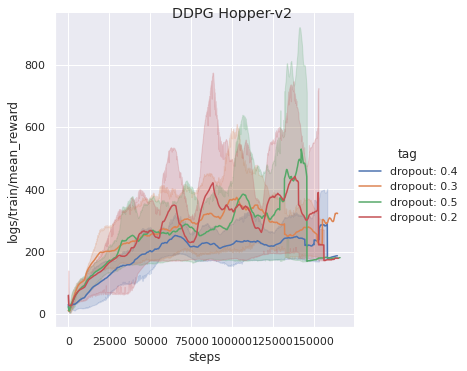

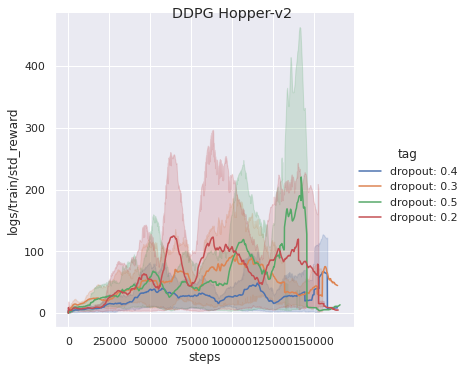

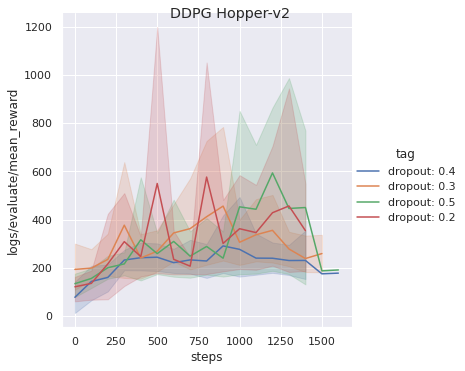

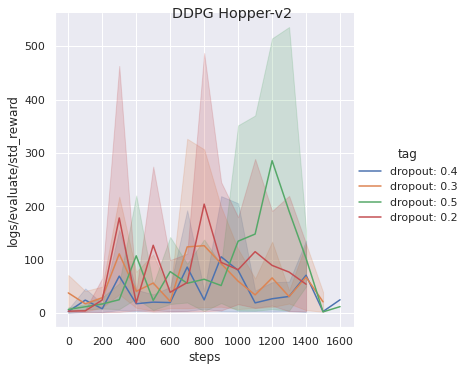

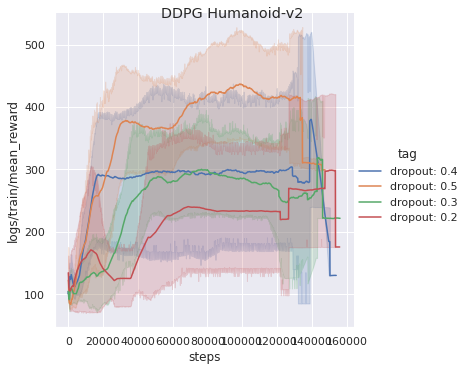

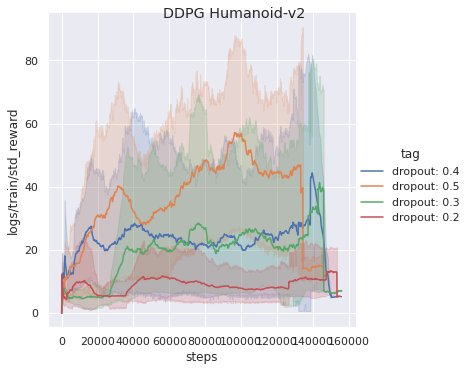

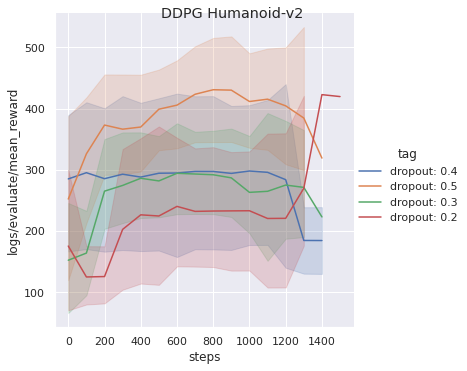

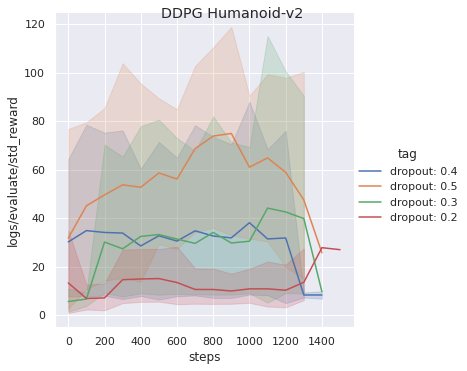

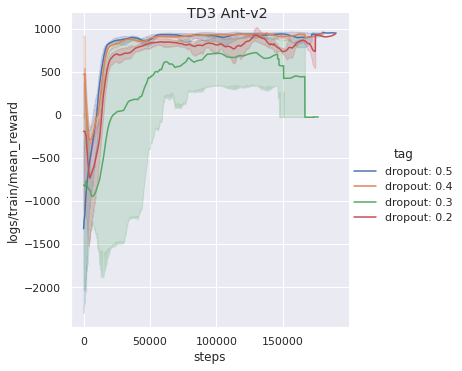

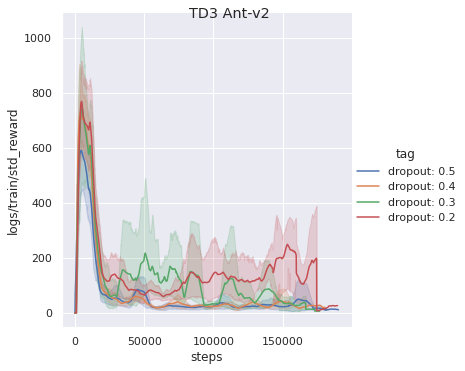

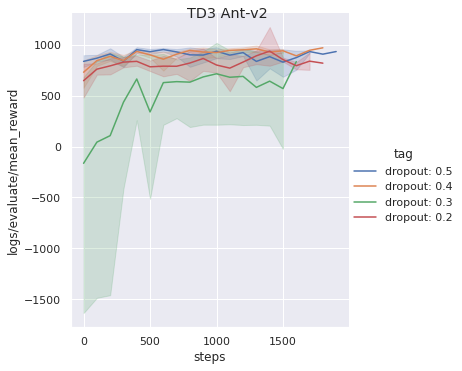

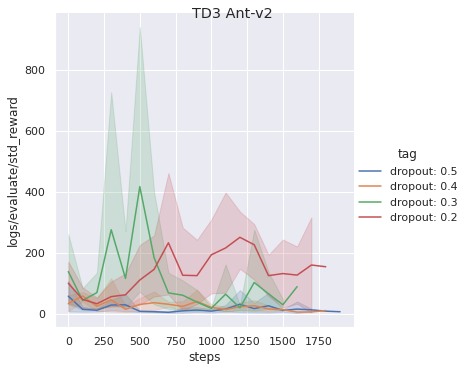

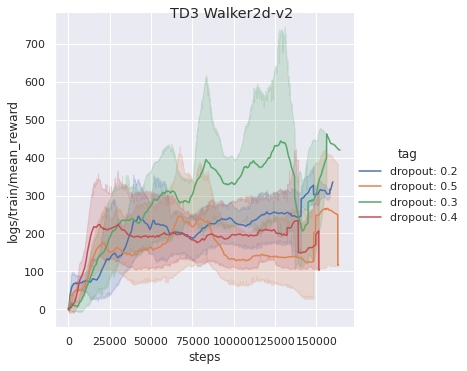

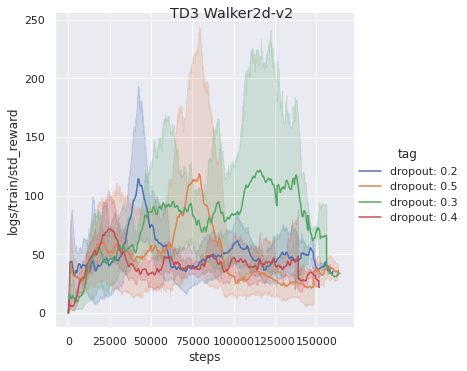

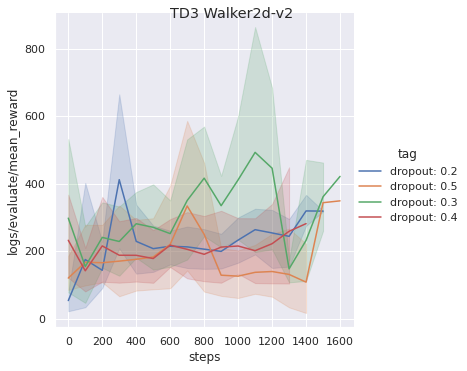

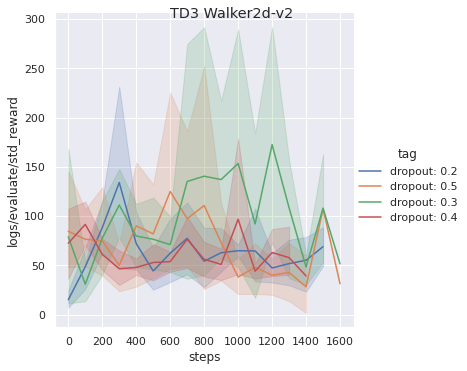

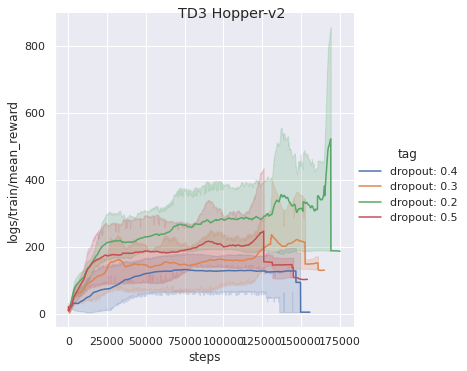

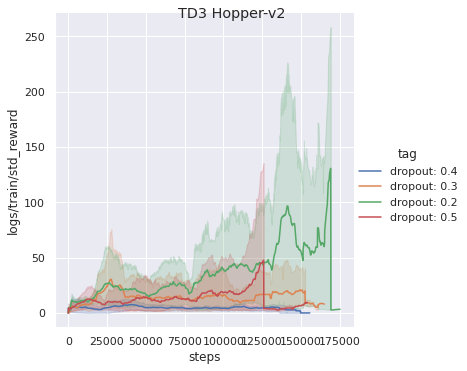

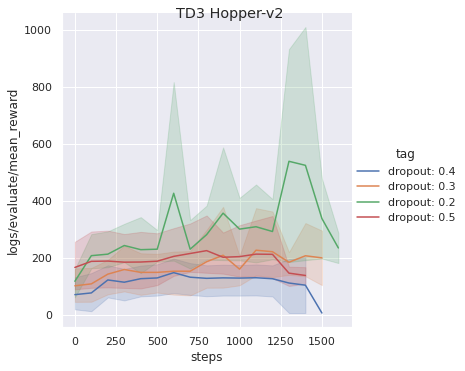

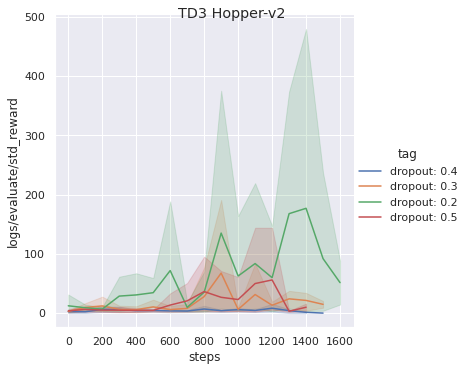

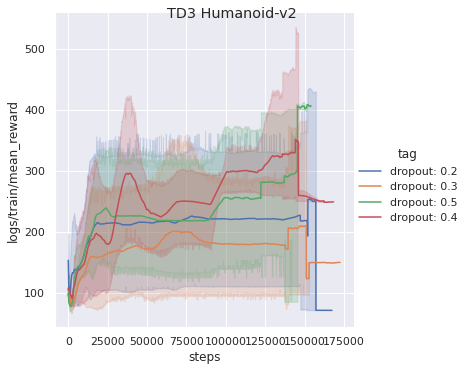

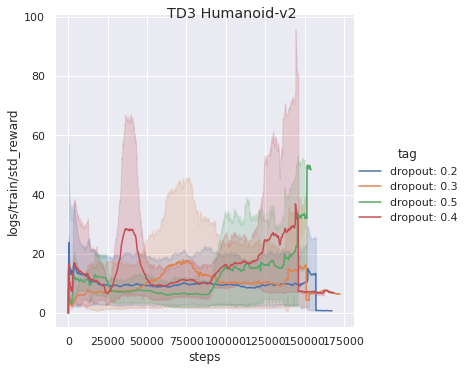

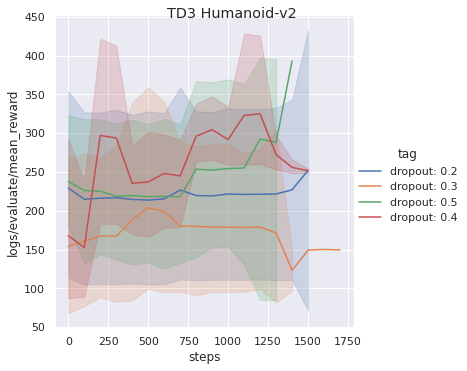

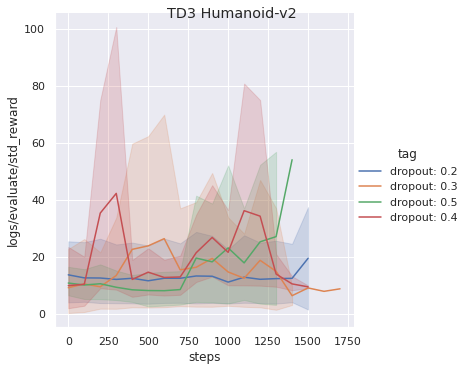

In [8]:
experiment_name = 'dropout'
tag_selector = lambda x: re.match(r'dropout', x)

base_dir = os.path.join(os.getcwd(), 'experiment_result')

for algorithm in tqdm(ALGO_TAGS, desc='algo'):
    for environment in tqdm(ENV_TAGS, desc='env'):

        print(f'Start preparing algorithm {algorithm} with {environment}.')

        all_tags_in_projects = get_all_existing_tags(project_table)
        chosen_projects_table = select_specified_rows(algorithm, environment, tag_selector, project_table)

        if chosen_projects_table.empty:
            print(f"WARNING! Don't find experiment in neptune - {algorithm}, {environment}")
            continue

        tags_assigned_to_exp = get_tags_assigned_to_experiment_dict(chosen_projects_table)
        experiments = list(chosen_projects_table['sys/id'])
        logs = BASIC_LOGS   # get_all_logs_name(chosen_projects_table)

        if not os.path.isdir(base_dir):
            os.mkdir(base_dir)

        path_to_experiment = os.path.join(base_dir, experiment_name)
        if not os.path.isdir(path_to_experiment):
            os.mkdir(path_to_experiment)

        path_to_experiment = os.path.join(path_to_experiment, f"{algorithm}_{environment}")
        if not os.path.isdir(path_to_experiment):
            os.mkdir(path_to_experiment)

        basic_results = {}
        for experiment in tqdm(experiments, desc="Downloading experiments results"):
                try:
                    basic_results[experiment] = pd.read_csv(os.path.join(path_to_experiment,  f"{experiment}.csv"))
                except FileNotFoundError:
                    results = download_basic_result_from_experiments(experiment)
                    basic_results[experiment] = results
                    pd.DataFrame(results).to_csv(os.path.join(path_to_experiment, f"{experiment}.csv"))

        concatenated_logs = {}
        for log in logs:
            if re.match(r'logs/train/', log):
                concatenated_logs[log] = concat_frames(basic_results, log, True, True)
            elif re.match(r'logs/evaluate/', log):
                concatenated_logs[log] = concat_frames(basic_results, log, False, False)

        make_plots(algorithm, environment, path_to_experiment, concatenated_logs)

print